In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.data_loader import load_stock_data, split_data
from utils.statistical_tests import find_cointegrated_pairs
from models.cointegration import CointegrationModel
from strategies.cointegrationtrading import CointegrationTrader
from utils.visualization import plot_trades

In [3]:
os.makedirs("results", exist_ok=True)

data_path = os.path.join("data", "jse_stocks.csv")
print(f"Chargement des données à partir de {data_path}...")

prices = pd.read_csv(data_path, index_col=0, parse_dates=True)
print(prices.shape)

try:
    sector_path = os.path.join("data", "jse_sectors.csv")
    sectors_df = pd.read_csv(sector_path)
    sectors = dict(zip(sectors_df["Ticker"], sectors_df["Sector"]))
    print(f"Informations sectorielles chargées pour {len(sectors)} actions")
except:
    sectors = {}
    print("Informations sectorielles non disponibles")

Chargement des données à partir de data\jse_stocks.csv...
(2616, 45)
Informations sectorielles chargées pour 45 actions


In [4]:
train_data, test_data = split_data(prices, train_ratio=0.9)
print(f"Données divisées: entraînement {train_data.shape}, test {test_data.shape}")

print("\nRecherche de paires co-intégrées (cela peut prendre quelques minutes)...")
cointegrated_pairs = find_cointegrated_pairs(train_data)

print(f"Trouvé {len(cointegrated_pairs)} paires co-intégrées")

Données divisées: entraînement (2354, 45), test (262, 45)

Recherche de paires co-intégrées (cela peut prendre quelques minutes)...
Trouvé 104 paires co-intégrées


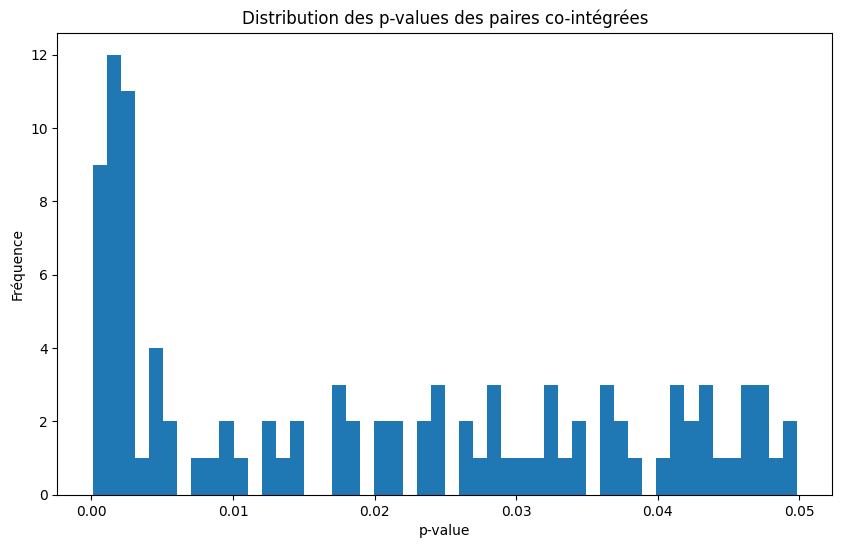

In [5]:
# plot p_values distribution
plt.figure(figsize=(10, 6))
plt.hist([pair[2] for pair in cointegrated_pairs], bins=50)
plt.title("Distribution des p-values des paires co-intégrées")
plt.xlabel("p-value")
plt.ylabel("Fréquence")
plt.show()


Analyse de la paire 1: CLH.JO - RDF.JO (p-value: 0.000084)
  Secteurs: CLH.JO (Consumer), RDF.JO (Property)
  Même secteur: Non

Analyse de la paire 2: AVI.JO - WBO.JO (p-value: 0.000100)
  Secteurs: AVI.JO (Industrials), WBO.JO (Construction)
  Même secteur: Non

Analyse de la paire 3: MNP.JO - REM.JO (p-value: 0.000163)
  Secteurs: MNP.JO (Industrials), REM.JO (Consumer)
  Même secteur: Non

Analyse de la paire 4: MNP.JO - WHL.JO (p-value: 0.000261)
  Secteurs: MNP.JO (Industrials), WHL.JO (Industrials)
  Même secteur: Oui

Analyse de la paire 5: MNP.JO - KIO.JO (p-value: 0.000493)
  Secteurs: MNP.JO (Industrials), KIO.JO (Industrials)
  Même secteur: Oui


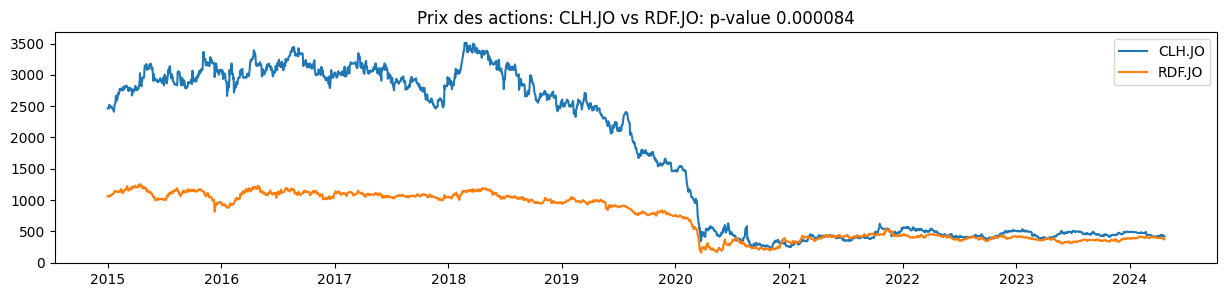

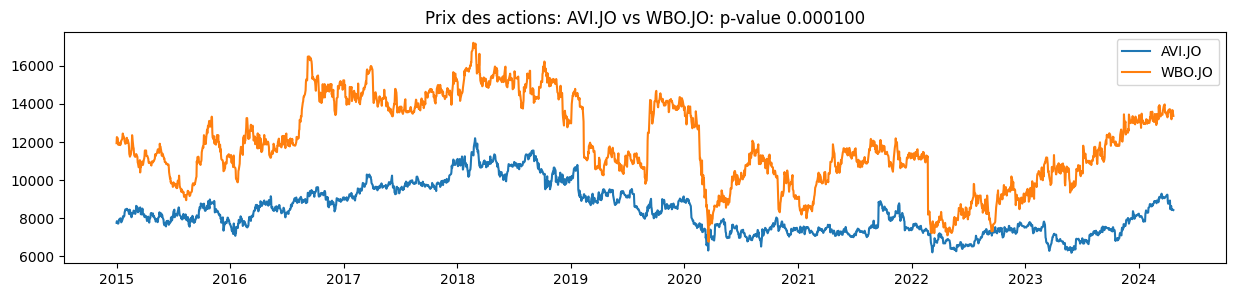

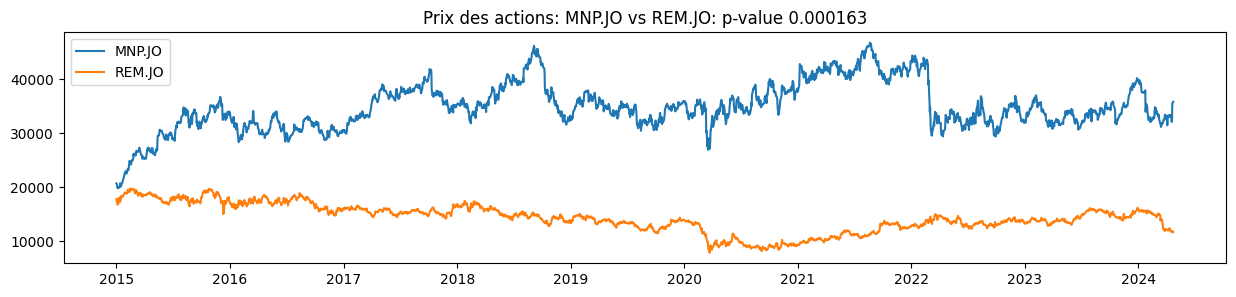

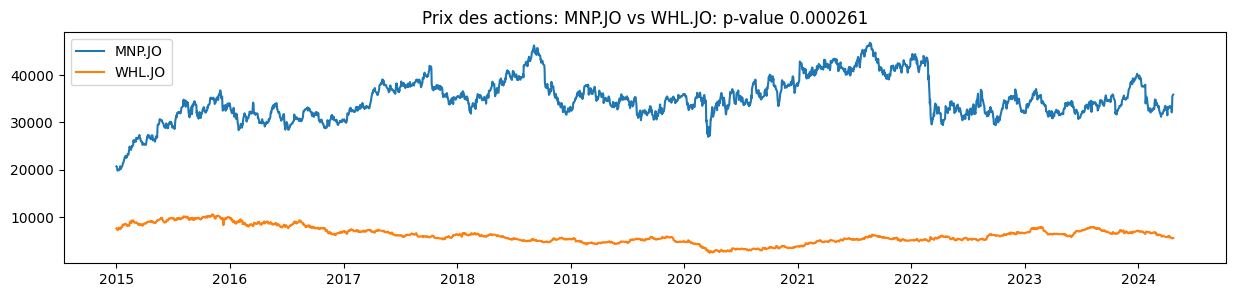

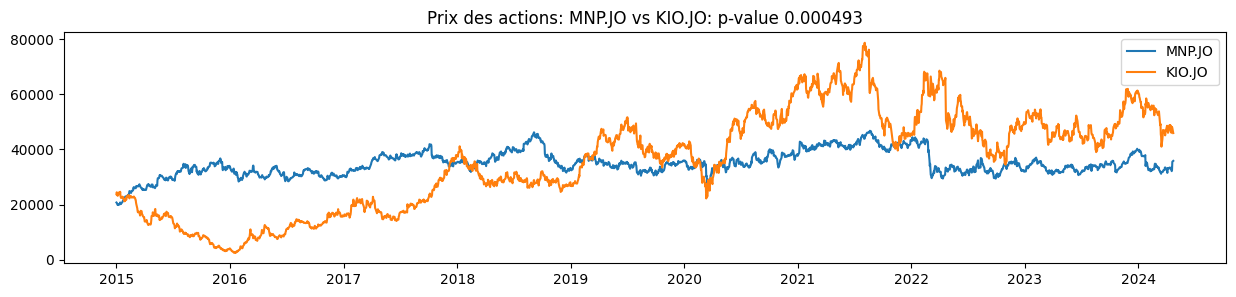

In [6]:
cointegrated_pairs.sort(key=lambda x: x[2])
top_pairs = cointegrated_pairs[:5]
results = []

for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})"
    )
    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    # Plot des prix, spread et résidus
    plt.figure(figsize=(15, 3))
    plt.plot(train_data[ticker1], label=ticker1)
    plt.plot(train_data[ticker2], label=ticker2)
    plt.title(f"Prix des actions: {ticker1} vs {ticker2}: p-value {p_value:.6f}")
    plt.legend()

In [13]:
model = CointegrationModel()
trader = CointegrationTrader(
            model, entry_threshold=2.0, stop_loss=0.05, profit_target=0.05
        )


Analyse de la paire 1: CLH.JO - RDF.JO (p-value: 0.000084)
  ⚠️  Aucun trade réalisé.

Analyse de la paire 2: AVI.JO - WBO.JO (p-value: 0.000100)
  Performance: Rendement total: 93.2112, Sharpe: 0.0550, Trades: 195


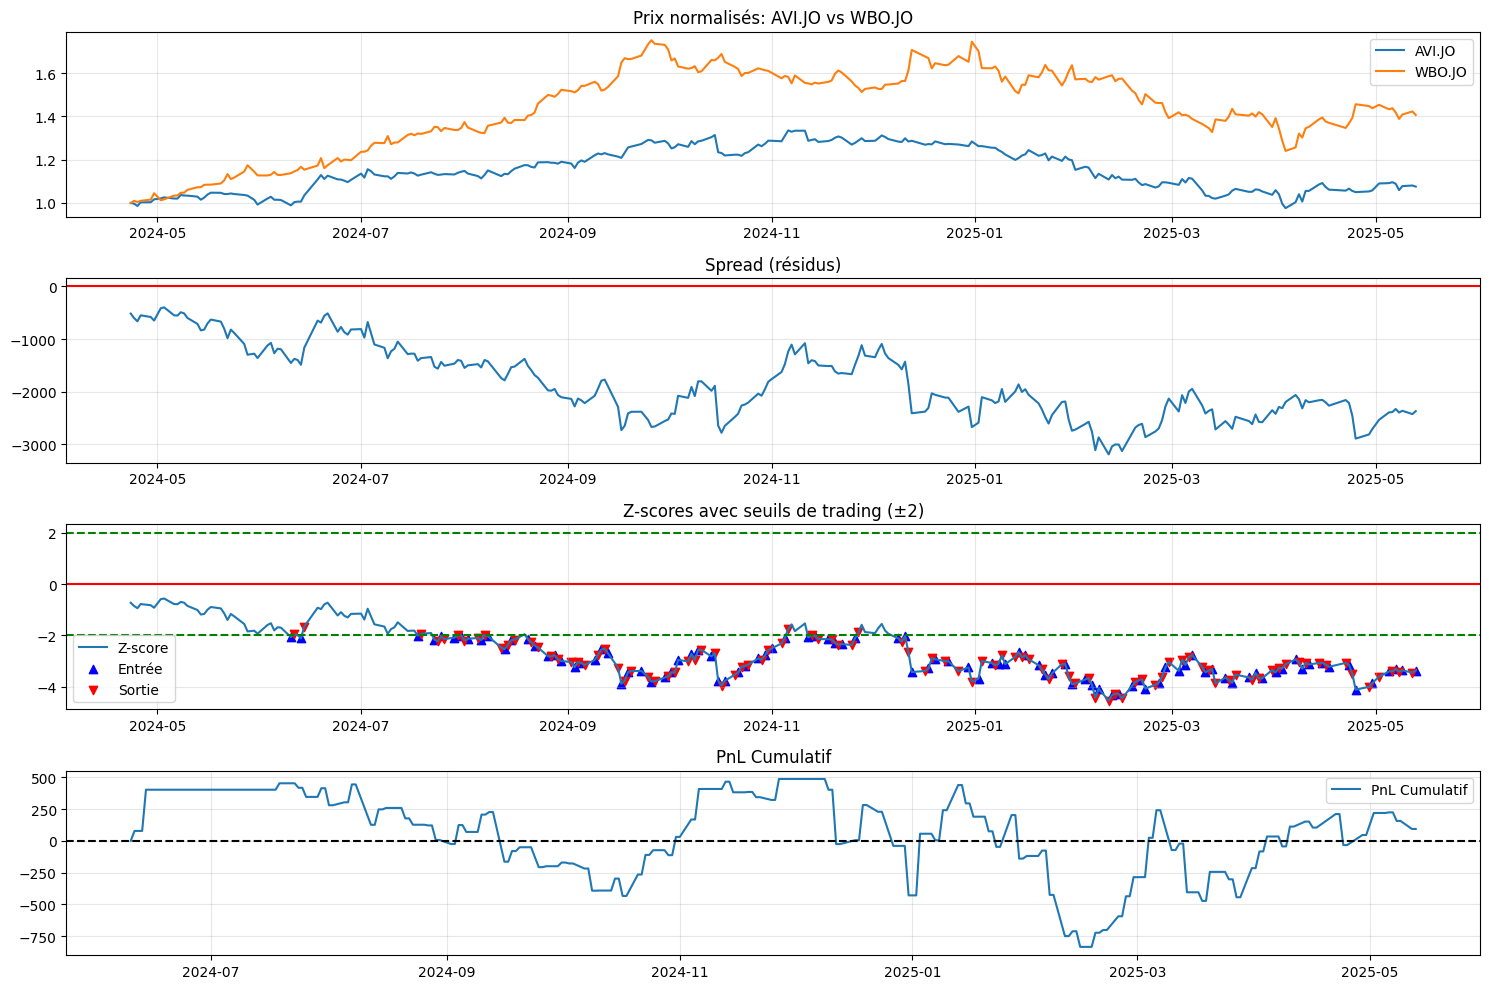


Analyse de la paire 3: MNP.JO - REM.JO (p-value: 0.000163)
  Performance: Rendement total: 946.6286, Sharpe: 0.3840, Trades: 18


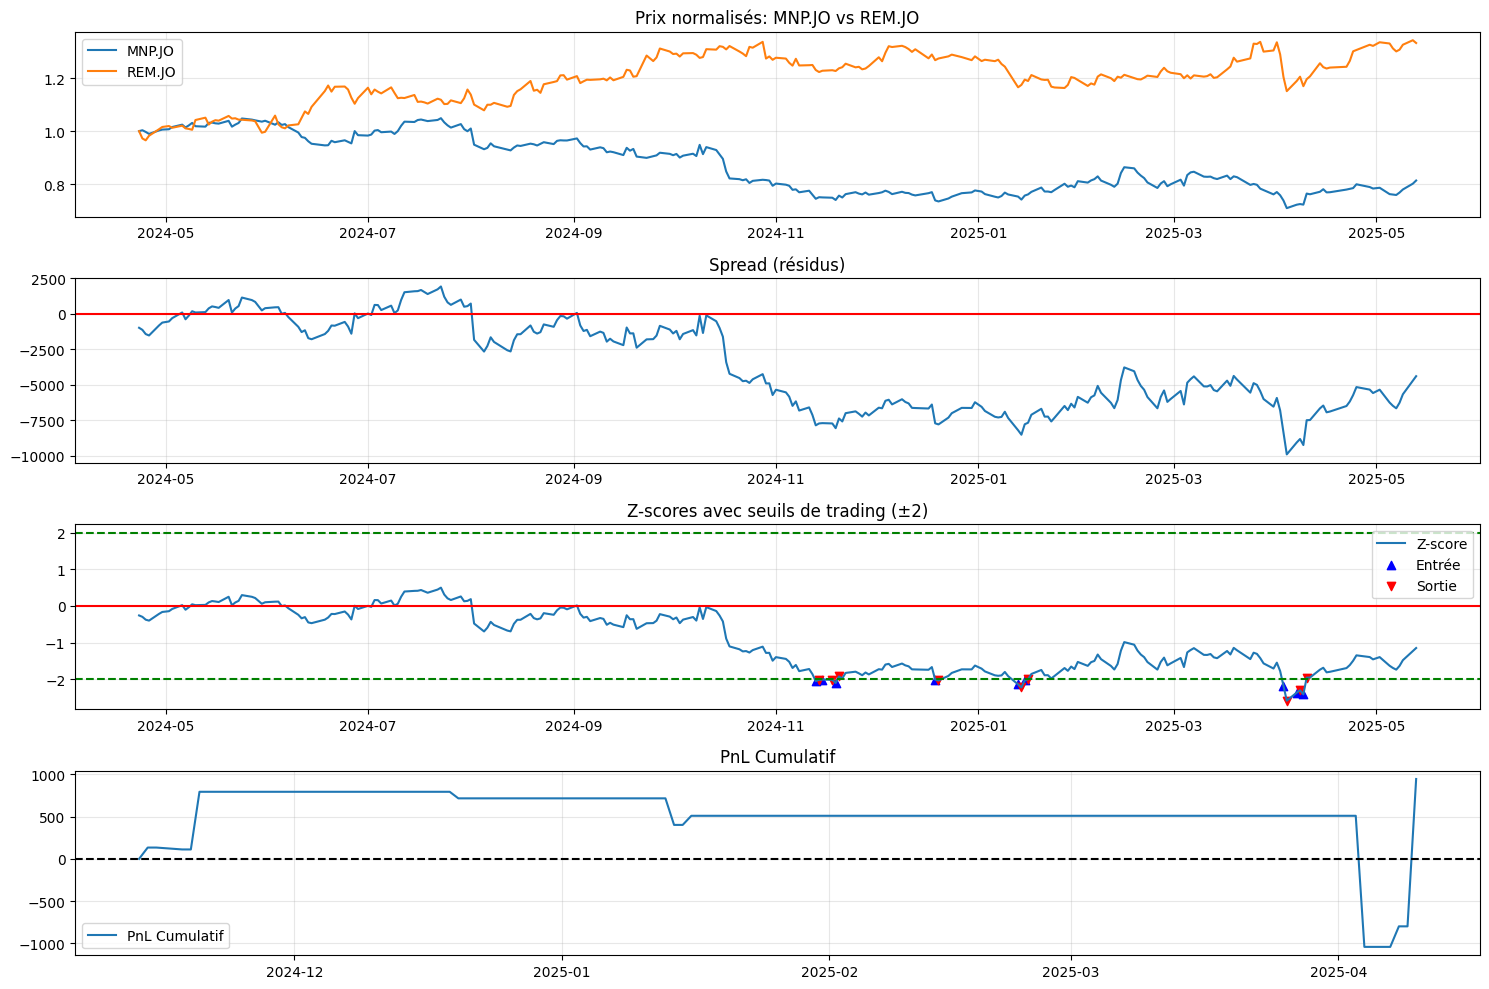


Analyse de la paire 4: MNP.JO - WHL.JO (p-value: 0.000261)
  Performance: Rendement total: 1900.9663, Sharpe: 0.9957, Trades: 46


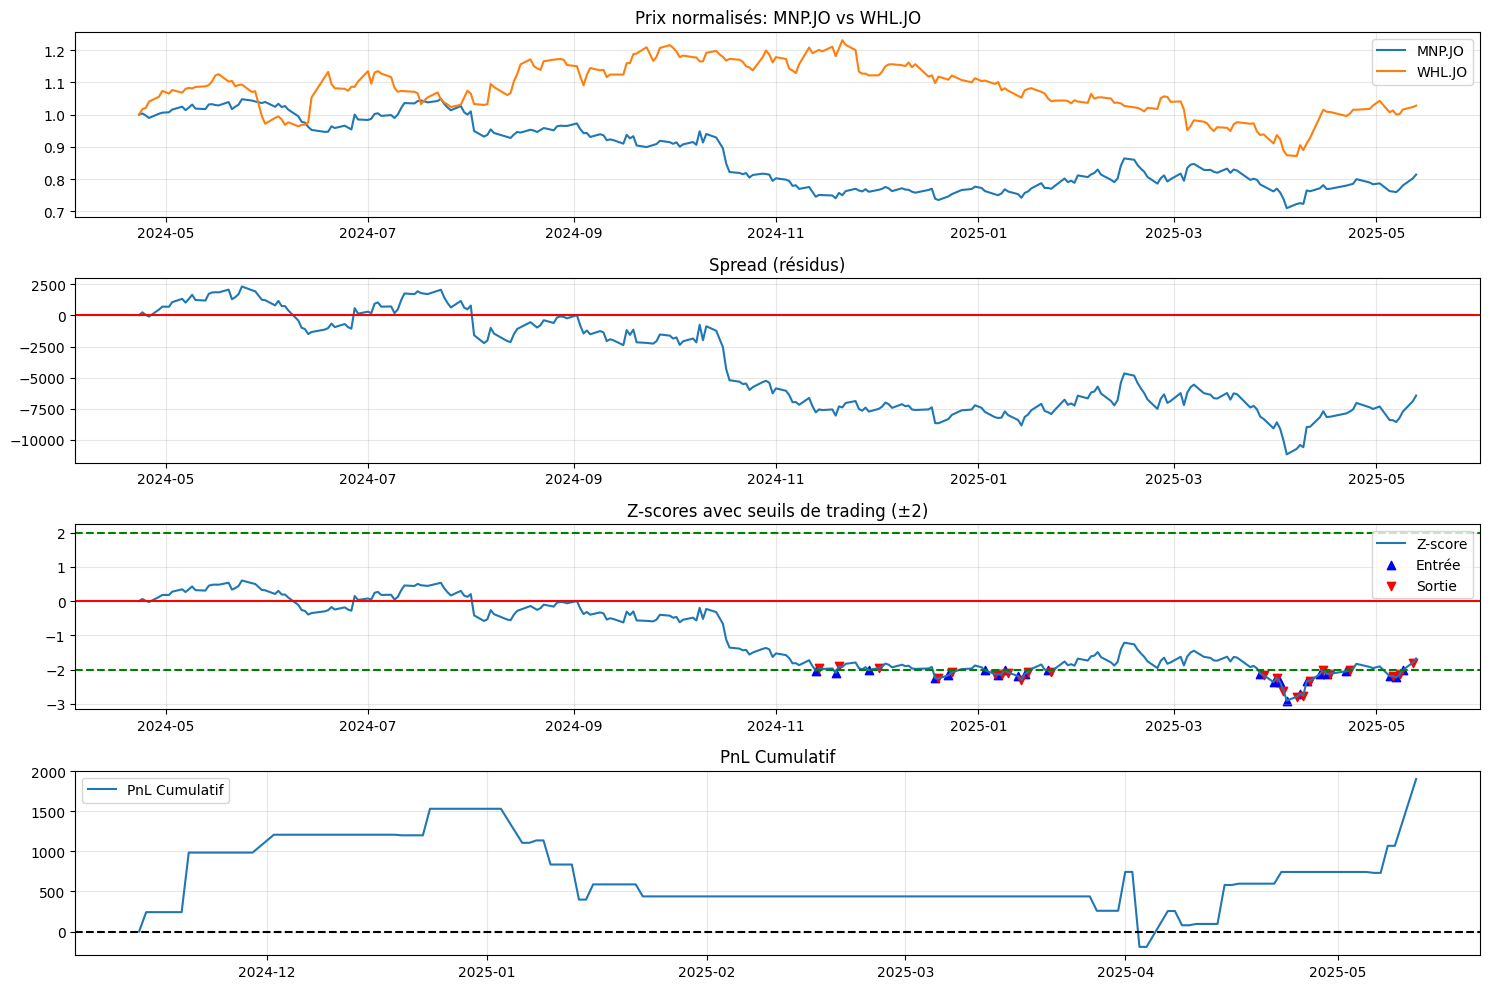


Analyse de la paire 5: MNP.JO - KIO.JO (p-value: 0.000493)
  Performance: Rendement total: 1502.1316, Sharpe: 0.8316, Trades: 24


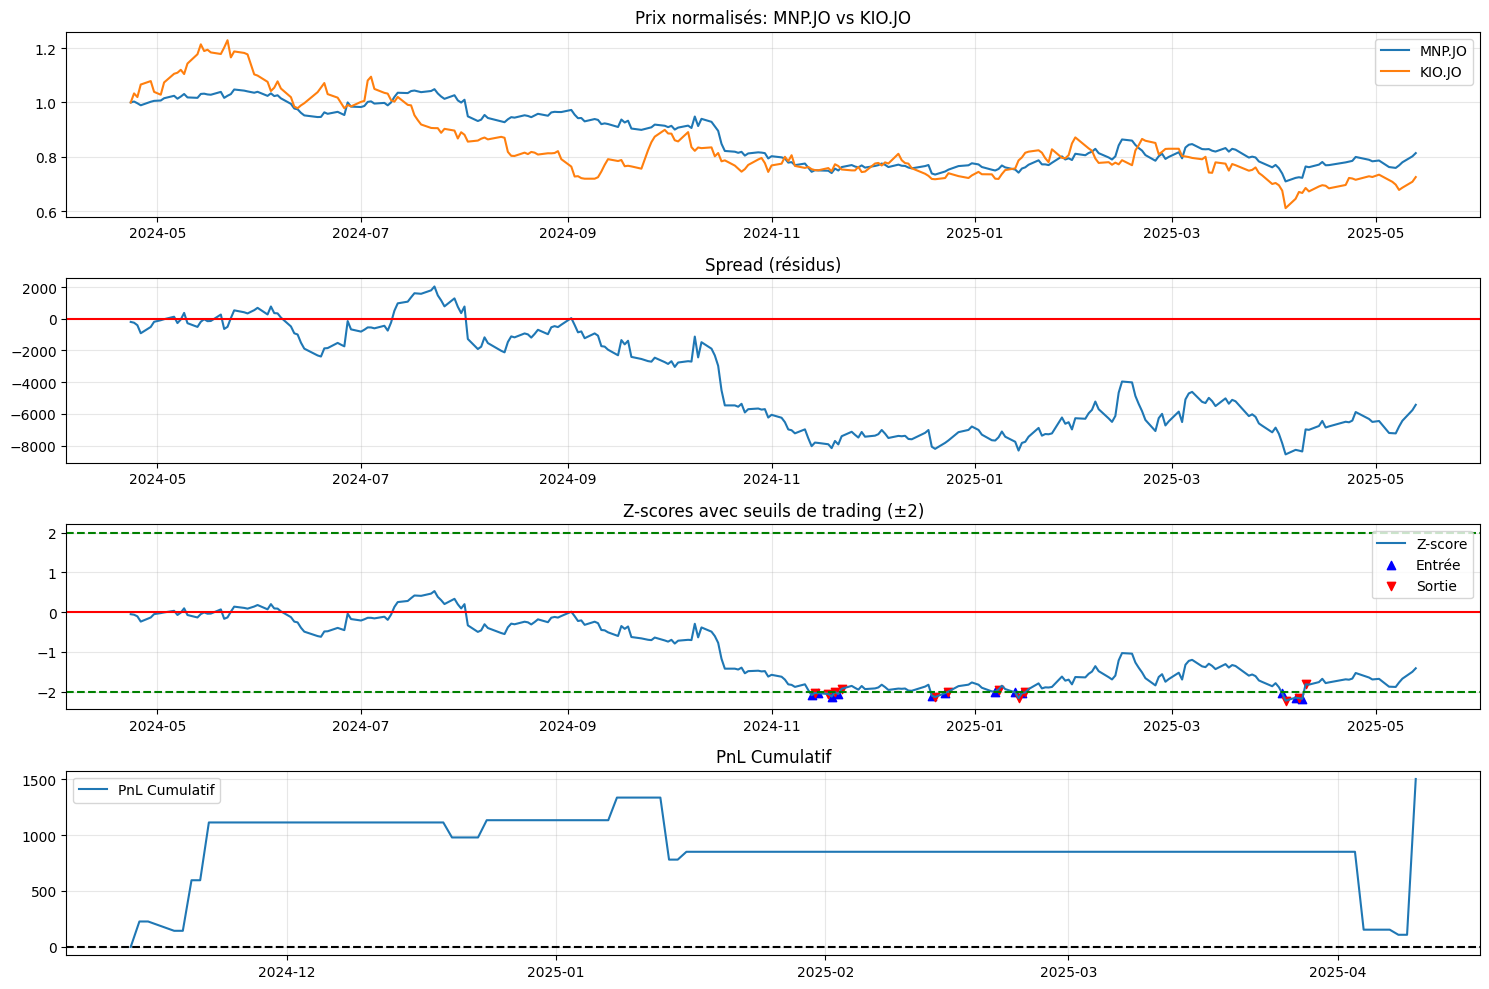

In [ ]:
for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    trades = trader.run_backtest(
            train_data[ticker1],
            train_data[ticker2],
            test_data[ticker1],
            test_data[ticker2],
        )
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")

    if trades.empty:
        print("  ⚠️  Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values

    if len(pnl_values) >= 2 and np.std(pnl_values) > 0:
        sharpe = np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
    else:
        sharpe = 0

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": model.beta,
            "Intercept": model.intercept,
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )
    plt.figure(figsize=(15, 10))
    
    # Normalisation des prix
    norm1 = test_data[ticker1] / test_data[ticker1].iloc[0]
    norm2 = test_data[ticker2] / test_data[ticker2].iloc[0]

    # Subplot 1: Prix normalisés
    plt.subplot(4, 1, 1)
    plt.plot(test_data.index, norm1, label=ticker1)
    plt.plot(test_data.index, norm2, label=ticker2)
    plt.title(f"Prix normalisés: {ticker1} vs {ticker2}")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Spread
    plt.subplot(4, 1, 2)
    plt.plot(test_data.index, trader.test_residuals, label="Spread")
    plt.axhline(y=0, color="r", linestyle="-")
    plt.title("Spread (résidus)")
    plt.grid(True, alpha=0.3)

    # Subplot 3: Z-scores avec seuils et points d'entrée/sortie
    plt.subplot(4, 1, 3)
    plt.plot(test_data.index, trader.z_scores, label="Z-score")
    plt.axhline(y=0, color="r", linestyle="-")
    plt.axhline(y=2, color="g", linestyle="--")
    plt.axhline(y=-2, color="g", linestyle="--")
    plt.title("Z-scores avec seuils de trading (±2)")

    # Ajouter les entrées/sorties si disponibles
    if not trades.empty:
        entries = trades[trades["position"] != 0]
        exits = trades[trades["position"] == 0]
        plt.scatter(entries["date"], entries["z_score"], color="blue", marker="^", label="Entrée")
        plt.scatter(exits["date"], exits["z_score"], color="red", marker="v", label="Sortie")
        plt.legend()

    plt.grid(True, alpha=0.3)

    # Subplot 4: PnL cumulatif
    plt.subplot(4, 1, 4)
    pnl_cum = trades.set_index("date")["pnl"].cumsum()
    plt.plot(pnl_cum.index, pnl_cum, label="PnL Cumulatif")
    plt.axhline(y=0, color="black", linestyle="--")
    plt.title("PnL Cumulatif")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
for i, (ticker1, ticker2, p_value) in enumerate(cointegrated_pairs):
    trades = trader.run_backtest(
            train_data[ticker1],
            train_data[ticker2],
            test_data[ticker1],
            test_data[ticker2],
        )
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")

    if trades.empty:
        print("  ⚠️  Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values

    if len(pnl_values) >= 2 and np.std(pnl_values) > 0:
        sharpe = np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
    else:
        sharpe = 0

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": model.beta,
            "Intercept": model.intercept,
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )

# print total pnl and mean pnl
total_pnl = sum([result["Total_Return"] for result in results])
mean_pnl = np.mean([result["Mean_PnL"] for result in results])
print(f"\nRendement total de toutes les paires: {total_pnl:.4f}")
print(f"Rendement moyen de toutes les paires: {mean_pnl:.4f}")


Analyse de la paire 1: CLH.JO - RDF.JO (p-value: 0.000084)
  ⚠️  Aucun trade réalisé.

Analyse de la paire 2: AVI.JO - WBO.JO (p-value: 0.000100)
  Performance: Rendement total: 93.2112, Sharpe: 0.0550, Trades: 195

Analyse de la paire 3: MNP.JO - REM.JO (p-value: 0.000163)
  Performance: Rendement total: 946.6286, Sharpe: 0.3840, Trades: 18

Analyse de la paire 4: MNP.JO - WHL.JO (p-value: 0.000261)
  Performance: Rendement total: 1900.9663, Sharpe: 0.9957, Trades: 46

Analyse de la paire 5: MNP.JO - KIO.JO (p-value: 0.000493)
  Performance: Rendement total: 1502.1316, Sharpe: 0.8316, Trades: 24

Analyse de la paire 6: INP.JO - SPP.JO (p-value: 0.000564)
  Performance: Rendement total: 660.2319, Sharpe: 0.2880, Trades: 180

Analyse de la paire 7: MNP.JO - BTI.JO (p-value: 0.000770)
  Performance: Rendement total: 1147.2166, Sharpe: 1.6267, Trades: 8

Analyse de la paire 8: MNP.JO - NTC.JO (p-value: 0.000884)
  Performance: Rendement total: 2088.8678, Sharpe: 0.5878, Trades: 108

Anal